In [4]:
import copy
import os
import warnings

import cv2
import lightly
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import plotly.express as px
import pytorch_lightning as pl
import seaborn as sns
import timm
import torch
import torch.nn as nn
import umap
from lightly.data import LightlyDataset
from PIL import Image
from torch import nn
from torch.utils.data import DataLoader
from umap import UMAP

from ssl_wafermap.data import WaferMapDataset
from ssl_wafermap.models.knn import VICReg
from ssl_wafermap.transforms import get_base_transforms, get_inference_transforms

torch.set_float32_matmul_precision("high")

# Ignore annoying pytorch lightning warnings
warnings.filterwarnings("ignore", ".*many workers.*")
warnings.filterwarnings("ignore", ".*meaningless.*")

save_dir = "../reports/figures/MixedWM38/"
os.makedirs(save_dir, exist_ok=True)

## Introduction

In [3]:
df_wm811k = pd.read_pickle("../data/processed/WM811K/train_data.pkl.xz")
df_mixed = pd.read_pickle("../data/processed/MixedWM38/train_data.pkl.xz")

In [110]:
sample_single = df_wm811k.query("failureType == 'Donut'").sample()
sample_mixed = df_mixed.query("failureType == 'D-L-ER-S'").sample()
display(sample_single), display(sample_mixed)

,waferMap,failureType,failureCode
29300,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",Donut,1


,waferMap,label,failureType,Normal,Center,Donut,Edge-Loc,Edge-Ring,Loc,Near-full,Scratch,Random
19523,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[0, 1, 0, 1, 1, 0, 1, 0]",D-L-ER-S,False,False,True,False,True,True,False,True,False


(None, None)

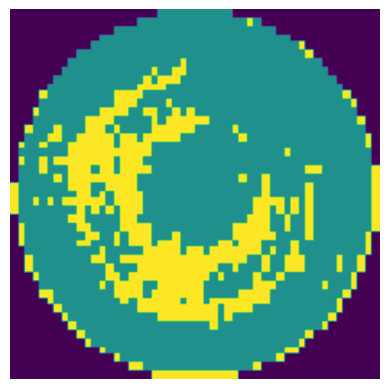

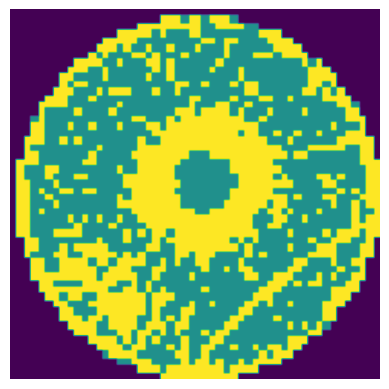

In [122]:
wafer_single = sample_single.waferMap.values[0]
wafer_mixed = sample_mixed.waferMap.values[0]

# Resize the images to be the same size, 128x128
wafer_single = Image.fromarray(wafer_single).resize((128, 128), Image.NEAREST)
wafer_mixed = Image.fromarray(wafer_mixed).resize((128, 128), Image.NEAREST)

# Plot the images
plt.imshow(wafer_single)
plt.axis("off")
plt.savefig(f"{save_dir}/single_wafer", bbox_inches="tight", dpi=300)
plt.show()

plt.imshow(wafer_mixed)
plt.axis("off")
plt.savefig(f"{save_dir}/mixed_wafer", bbox_inches="tight", dpi=300)
plt.show()

## Methods

In [ ]:
from ssl_wafermap.utilities.transforms import get_base_transforms
import torch

transforms = get_base_transforms(denoise=True, normalize=False)
wafer_mixed = df_mixed.query("failureType != 'R'").sample().waferMap.values[0]

# Apply the transforms to the images
transforms(torch.from_numpy(wafer_mixed))[0]
transformed_images = [transforms(torch.from_numpy(wafer_mixed))[0] for _ in range(4)]

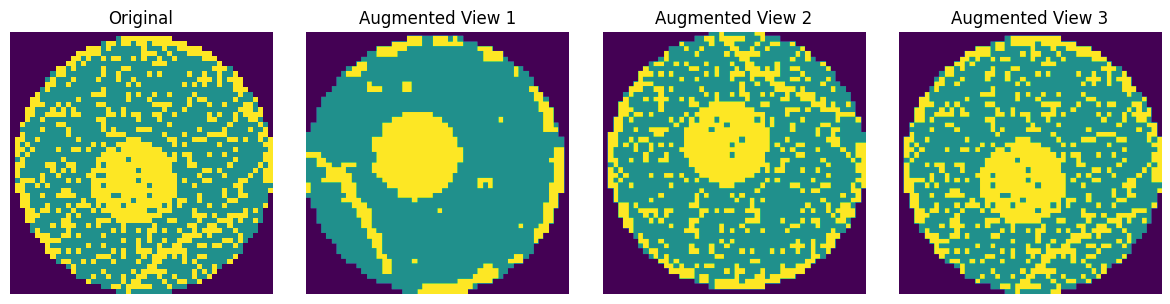

In [217]:
# Plot the transformed images and the original
fig, axes = plt.subplots(1, 4, figsize=(12, 3))
for i, ax in enumerate(axes):
    if i == 0:
        ax.imshow(wafer_mixed)
        ax.set_title("Original")
    else:
        ax.imshow(transformed_images[i - 1])
        ax.set_title(f"Augmented View {i}")
    ax.axis("off")
plt.savefig(f"{save_dir}/transformed wafers", bbox_inches="tight", dpi=300)
plt.tight_layout()
plt.show()

## Results

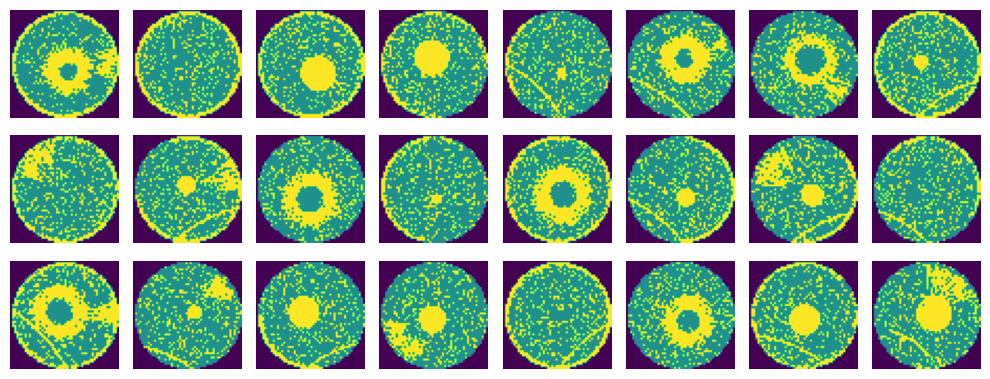

In [237]:
# Grab 24 random images from the dataset (with unique failure types) and plot them in a 3x8 grid
sample = df_mixed.query("failureType != 'R'").sample(24)
fig, axes = plt.subplots(3, 8, figsize=(10, 4))
for i, ax in enumerate(axes.flatten()):
    ax.imshow(sample.waferMap.values[i])
    ax.axis("off")
plt.savefig(f"{save_dir}/mixed_wafer_grid", bbox_inches="tight", dpi=300)
plt.tight_layout()
plt.show()

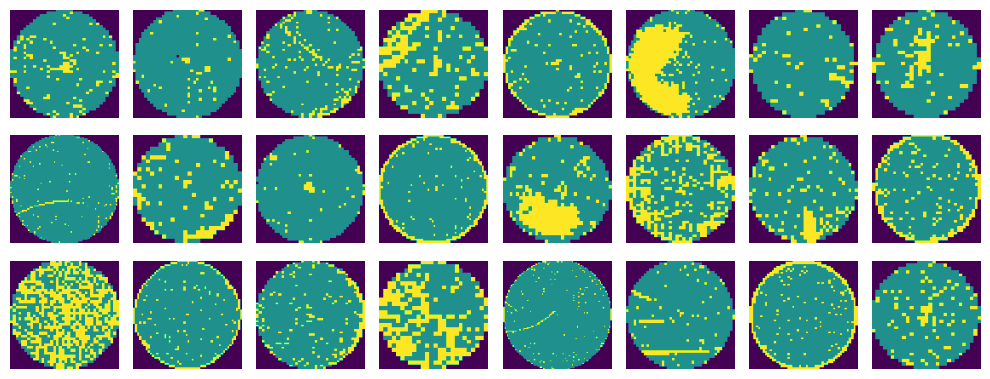

In [246]:
# Now do the same for the single dataset
sample = df_wm811k.query("failureType != 'None'").sample(24)
fig, axes = plt.subplots(3, 8, figsize=(10, 4))
for i, ax in enumerate(axes.flatten()):
    ax.imshow(Image.fromarray(sample.waferMap.values[i]).resize((128, 128), Image.NEAREST), cmap="viridis")
    ax.axis("off")
plt.savefig(f"{save_dir}/single_wafer_grid", bbox_inches="tight", dpi=300)
plt.tight_layout()

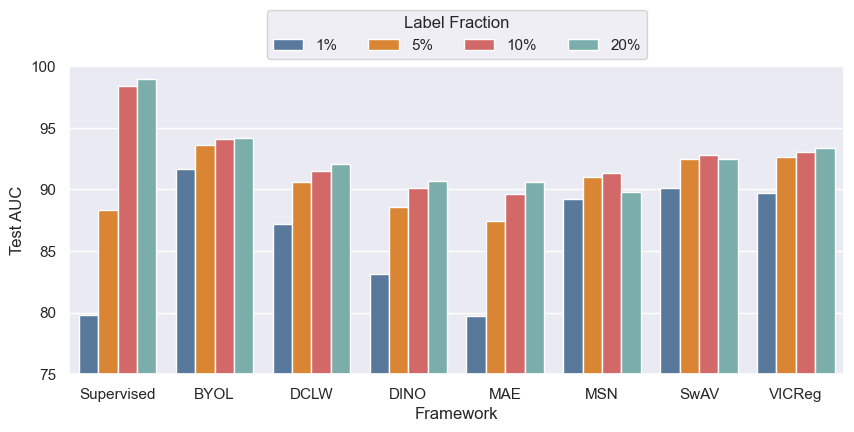

In [314]:
# Make a graph of the following
# Framework  1% 5% 10% 20%
# (Supervised)  79.8 88.3 98.4 99.0
# BYOL  91.7 93.6 94.1 94.2
# DCLW  87.2 90.6 91.5 92.1
# DINO  83.1 88.6 90.1 90.7
# MAE  79.7 87.4 89.6 90.6
# MSN  89.2 91.0 91.3 89.8
# SwAV  90.1 92.5 92.8 92.5
# VICReg  89.7 92.6 93.0 93.4

import plotly.express as px

data = pd.DataFrame(
    {
        "Framework": [
            "Supervised",
            "BYOL",
            "DCLW",
            "DINO",
            "MAE",
            "MSN",
            "SwAV",
            "VICReg",
        ],
        "1%": [79.8, 91.7, 87.2, 83.1, 79.7, 89.2, 90.1, 89.7],
        "5%": [88.3, 93.6, 90.6, 88.6, 87.4, 91.0, 92.5, 92.6],
        "10%": [98.4, 94.1, 91.5, 90.1, 89.6, 91.3, 92.8, 93.0],
        "20%": [99.0, 94.2, 92.1, 90.7, 90.6, 89.8, 92.5, 93.4],
    }
)

data = data.melt(id_vars="Framework", var_name="Percent", value_name="AUC")

sns.set_theme(style="darkgrid")
# sns.set_palette("colorblind")
# sns.set_context("paper", font_scale=1.5)
fig, ax = plt.subplots(figsize=(10, 4))
sns.barplot(data=data, x="Framework", y="AUC", hue="Percent", ax=ax, palette=px.colors.qualitative.T10)
ax.set_ylabel("Test AUC")
ax.set_xlabel("Framework")
ax.set_ylim(75, 100)
# ax.legend(title="Percent of Training Data", loc="lower right")
sns.move_legend(ax, "lower center", bbox_to_anchor=(0.5, 1.0), ncol=4, title="Label Fraction")
plt.savefig(f"{save_dir}/framework_comparison_barplot.png", bbox_inches="tight", dpi=300)
plt.show()

## Embeddings

In [63]:
class SupervisedR18(pl.LightningModule):
    def __init__(self, num_classes=8, pos_weight=None):
        super().__init__()
        # The backbone will only be used for feature extraction
        self.backbone = timm.create_model("resnet18", pretrained=False, num_classes=0)
        # Full model will be used for training
        self.model = timm.create_model(
            "resnet18", pretrained=False, num_classes=num_classes
        )
        self.criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight)

    def forward(self, x):
        return self.backbone(x)

    def predict_step(self, batch, batch_idx):
        images, _, _ = batch
        return self.backbone(images)

In [64]:
ckpt_dict = {
    "VICReg": (
        VICReg,
        "../models/mixed_wm38_pretrain/wafermaps/version_2/VICReg/checkpoints/epoch=149-step=62250.ckpt",
    ),
    # "BYOL": (
    #     BYOL,
    #     "../models/mixed_wm38_pretrain/wafermaps/version_2/BYOL/checkpoints/epoch=149-step=62250.ckpt",
    # ),
    # "DCLW": (
    #     DCLW,
    #     "../models/mixed_wm38_pretrain/wafermaps/version_2/DCLW/checkpoints/epoch=149-step=62250.ckpt",
    # ),
    # "DINO": (
    #     DINOViT,
    #     "../models/mixed_wm38_pretrain/wafermaps/version_4/DINOViT/checkpoints/epoch=149-step=62250.ckpt",
    # ),
    # "MAE": (
    #     MAE2,
    #     "../models/mixed_wm38_pretrain/wafermaps/version_2/MAE/checkpoints/epoch=149-step=62250.ckpt",
    # ),
    # "MSN": (
    #     MSN,
    #     "../models/mixed_wm38_pretrain/wafermaps/version_2/MSN/checkpoints/epoch=149-step=62250.ckpt",
    # ),
    # "SwaV": (
    #     SwaV,
    #     "../models/mixed_wm38_pretrain/wafermaps/version_2/SwaV/checkpoints/epoch=149-step=62250.ckpt",
    # ),
    "Supervised": (
        SupervisedR18,
        "../models/mixedwm38_finetune/supervised/version_0/train_20_split/checkpoints/epoch=17-step=2124.ckpt",
    ),
    
}

train_data = pd.read_pickle("../data/processed/MixedWM38/train_data.pkl.xz")

embeddings = {}

for name, (model_class, ckpt_path) in ckpt_dict.items():
    # ckpt = 
    model = model_class()
    state_dict = torch.load(ckpt_path)["state_dict"]
    if name == "Supervised":
        del state_dict["criterion.pos_weight"]
    else:
        state_dict["dummy_param"] = torch.zeros(0)
    model.load_state_dict(state_dict)
    inference_trainer = pl.Trainer(
        accelerator="auto",
        precision="16-mixed",
        enable_checkpointing=False,
        enable_model_summary=False,
        enable_progress_bar=True,
        inference_mode=True,
        logger=False,
    )

    train_dataset = LightlyDataset.from_torch_dataset(
        WaferMapDataset(
            train_data.waferMap, train_data.failureType.factorize(sort=True)[0]
        ),
        transform=get_inference_transforms(),
    )
    train_loader = DataLoader(
        train_dataset,
        batch_size=256,
        shuffle=False,
        num_workers=0,
        drop_last=False,
    )

    train_features = inference_trainer.predict(model, train_loader)
    train_features = torch.cat(train_features, dim=0).detach().cpu().numpy()

    reducer = umap.UMAP(random_state=0, verbose=True)
    # Perform supervised reduction to exaggerate class separation
    reducer.fit(train_features, y=train_data.failureType.factorize(sort=True)[0])
    train_embedding = reducer.transform(train_features)

    train_emb = pd.DataFrame(train_embedding, columns=["x", "y"])

    embeddings[name] = train_emb

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

UMAP(random_state=0, verbose=True)
Fri May  5 01:57:26 2023 Construct fuzzy simplicial set
Fri May  5 01:57:26 2023 Finding Nearest Neighbors
Fri May  5 01:57:26 2023 Building RP forest with 13 trees
Fri May  5 01:57:26 2023 NN descent for 15 iterations
	 1  /  15
	 2  /  15
	 3  /  15
	Stopping threshold met -- exiting after 3 iterations
Fri May  5 01:57:27 2023 Finished Nearest Neighbor Search
Fri May  5 01:57:27 2023 Construct embedding


Epochs completed:   0%|            0/200 [00:00]

Fri May  5 01:57:39 2023 Finished embedding


Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

UMAP(random_state=0, verbose=True)
Fri May  5 01:58:15 2023 Construct fuzzy simplicial set
Fri May  5 01:58:15 2023 Finding Nearest Neighbors
Fri May  5 01:58:15 2023 Building RP forest with 13 trees
Fri May  5 01:58:15 2023 NN descent for 15 iterations
	 1  /  15
	 2  /  15
	 3  /  15
	 4  /  15
	Stopping threshold met -- exiting after 4 iterations
Fri May  5 01:58:15 2023 Finished Nearest Neighbor Search
Fri May  5 01:58:15 2023 Construct embedding


Epochs completed:   0%|            0/200 [00:00]

Fri May  5 01:58:25 2023 Finished embedding


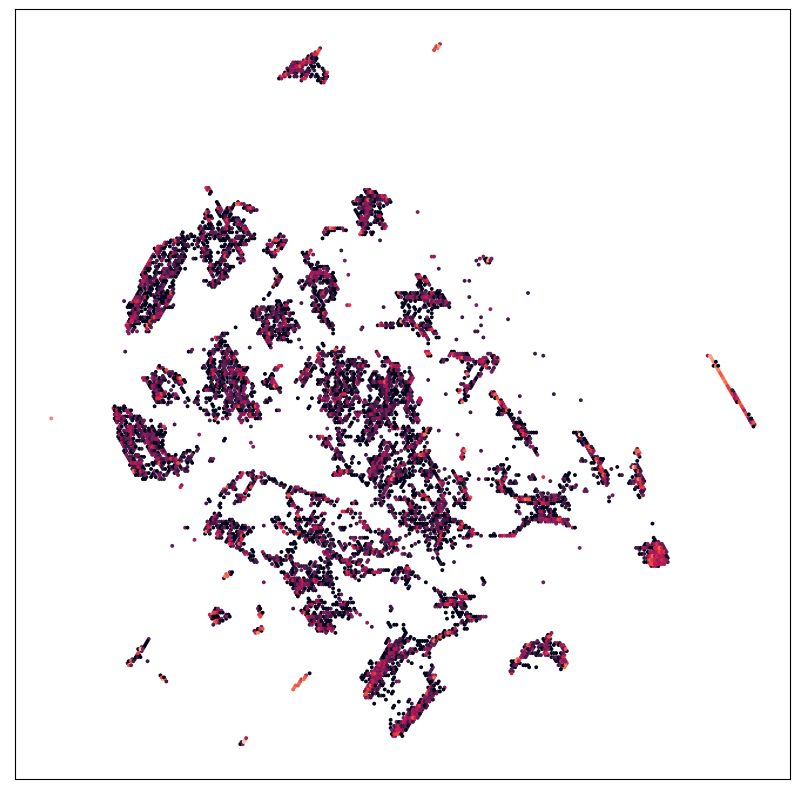

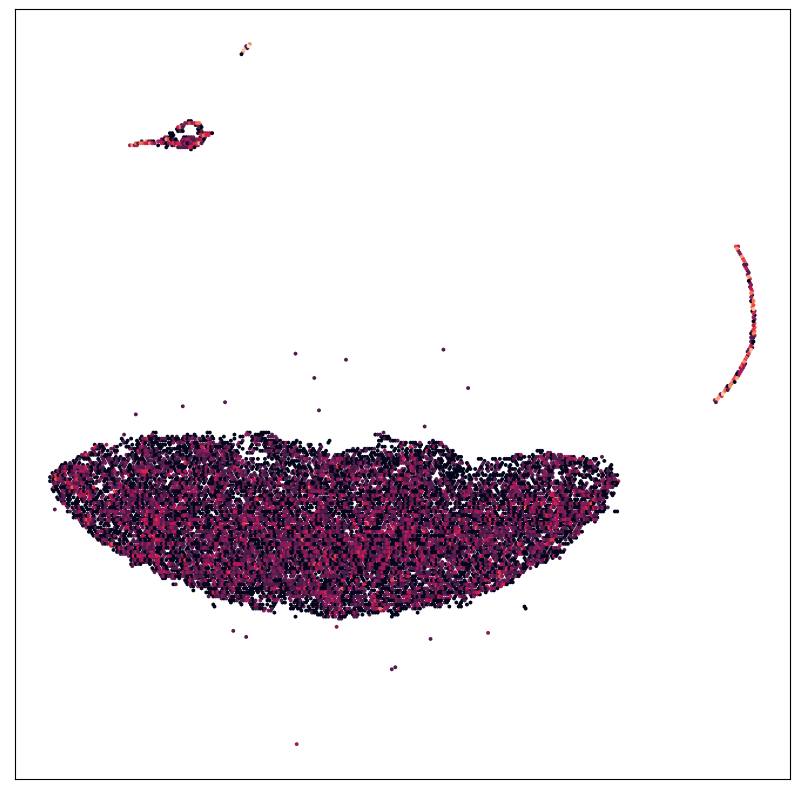

In [74]:
ssl_emb = embeddings["VICReg"]
sup_emb = embeddings["Supervised"]

# Plot hexbins side by side
fig = plt.figure(figsize=(10, 10))
plt.hexbin(ssl_emb.x, ssl_emb.y, gridsize=300, bins="log", mincnt=1, cmap="rocket")
plt.xticks([])
plt.yticks([])
plt.savefig(f"{save_dir}/ssl_hexbin.png", bbox_inches="tight", dpi=300)
plt.show()

fig = plt.figure(figsize=(10, 10))
plt.hexbin(sup_emb.x, sup_emb.y, gridsize=300, bins="log", mincnt=1, cmap="rocket")
plt.xticks([])
plt.yticks([])
plt.savefig(f"{save_dir}/sup_hexbin.png", bbox_inches="tight", dpi=300)
plt.show()